# Bitcoin Price Direction Prediction Using Random Forest Classification

**CPSC 322 - Introduction to Data Science**  
**Fall 2025**

**Author:** Chris Wong 
**Date:** December 2, 2025

---

In [41]:
# Import standard libraries
import pandas as pd
import numpy as np
import importlib

# Import and reload mysklearn package modules
import mysklearn.myutils
importlib.reload(mysklearn.myutils)
import mysklearn.myutils as myutils

import mysklearn.mypytable
importlib.reload(mysklearn.mypytable)
from mysklearn.mypytable import MyPyTable 

import mysklearn.myclassifiers
importlib.reload(mysklearn.myclassifiers)
from mysklearn.myclassifiers import MyDecisionTreeClassifier

import mysklearn.myevaluation
importlib.reload(mysklearn.myevaluation)
from mysklearn.myevaluation import (
    stratified_kfold_split, 
    confusion_matrix, 
    accuracy_score,
    binary_precision_score, 
    binary_recall_score, 
    binary_f1_score
)

## Abstract

This project develops a Random Forest classifier to predict Bitcoin price direction ("Up" or "Down") using trading volume, social media sentiment, and U.S. Treasury indicators. Our dataset contains 1,074 daily observations spanning December 2022 to November 2025. The Random Forest ensemble (N=100 trees, M=3 best, F=8 features) achieved 50.2% test accuracy, performing at baseline random chance. This report presents data analysis, temporal visualizations, classifier implementation, and performance evaluation.

## 1. Introduction

This project predicts Bitcoin price direction ("Up" or "Down") using machine learning classification. Our dataset contains 1,074 daily observations (December 2022 - November 2025) with 27 features including trading volume, social media sentiment, and U.S. Treasury indicators.

We implemented a Random Forest classifier using ensemble learning. Random Forests combine multiple decision trees trained on bootstrap samples with random feature selection to create robust predictions resistant to overfitting.

**Key Findings:** Our Random Forest model (N=100 trees, M=3 best, F=8 features) achieved 50.2% test accuracy across five runs. This performance at the 50% baseline indicates that the current feature set (sentiment and volume) does not provide strong predictive signal for next-day price movements, with consistent performance (±2.2% std) despite Bitcoin's volatility.

## 2. Data Analysis

This section analyzes the Bitcoin sentiment dataset through attribute descriptions, summary statistics, and visualizations.

### 2.1 Dataset Overview and Attribute Information

The dataset contains **1,076 instances** (daily observations from December 2022 to November 2025) with **27 attributes**:

1. **Temporal (4):** `timestamp`, `datetime_utc`, `merge_date`, row index
2. **Market Trading (5):** `open`, `high`, `low`, `close`, `volume` (USD and Bitcoin units)
3. **Sentiment (2):** `weighted_sentiment` (-1 to +1 scale), `sentiment_missing` flag
4. **Treasury Indicators (16):** Federal financing, foreign series, treasury bills/bonds/notes, and other debt metrics

**Classification Label:**
- `price_direction`: Binary ("Up" or "Down") created by comparing daily close prices

**Data Integrity:** OHLC price features are removed after label creation to prevent data leakage. The model uses only volume, sentiment, and treasury indicators.

### 2.2 Dataset Loading and Initial Examination

In [8]:
# Load the bitcoin sentiment dataset
df = pd.read_csv('input_data/bitcoin_sentiment.csv')

# Print dataset shape
print("Dataset Shape:")
print(f"  Rows: {df.shape[0]}")
print(f"  Columns: {df.shape[1]}")
print()


# Print headers (column names)
print("Column Headers:")
print(df.columns.tolist())
print()

# Print first few rows
print("First 5 Rows:")
print(df.head())
print()

Dataset Shape:
  Rows: 1074
  Columns: 28

Column Headers:
['Unnamed: 0', 'timestamp', 'open', 'high', 'low', 'close', 'volume', 'datetime_utc', 'merge_date', 'domestic_series', 'federal_financing_bank', 'foreign_series', 'government_account_series', 'government_account_series_inflation_securities', 'special_purpose_vehicle', 'state_and_local_government_series', 'total_interest-bearing_debt', 'total_marketable', 'total_non-marketable', 'treasury_bills', 'treasury_bonds', 'treasury_floating_rate_notes_(frn)', 'treasury_inflation-protected_securities_(tips)', 'treasury_notes', 'united_states_savings_inflation_securities', 'united_states_savings_securities', 'weighted_sentiment', 'sentiment_missing']

First 5 Rows:
   Unnamed: 0      timestamp      open      high       low     close  \
0           0  1669852800000  17165.44  17317.80  16855.00  16980.08   
1           1  1669939200000  16980.07  17108.25  16791.02  17094.71   
2           2  1670025600000  17094.25  17158.42  16863.58  16

### 2.3 Continuous Feature Relationships

Scatter plots reveal correlations between sentiment, price, and volume in the raw continuous data.

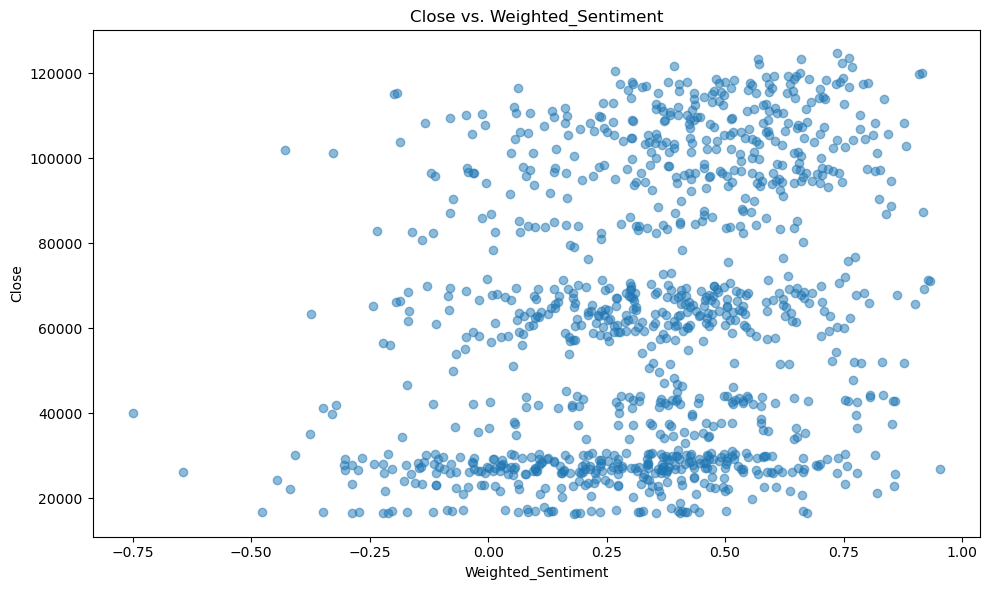

In [9]:
# Scatter Plot 1: Weighted Sentiment vs. Close Price
# Shows relationship between market sentiment and closing prices
from mysklearn.plot_utils import plot_scatter

# Convert DataFrame to MyPyTable for plotting
bitcoin_table = MyPyTable(column_names=df.columns.tolist(), data=df.values.tolist())
plot_scatter(bitcoin_table, "weighted_sentiment", "close")

**Figure 1:** Scatter plot showing the relationship between weighted sentiment (x-axis) and Bitcoin closing price (y-axis). Points are distributed across all sentiment levels at various price points, suggesting sentiment alone does not determine price levels but may influence short-term direction.

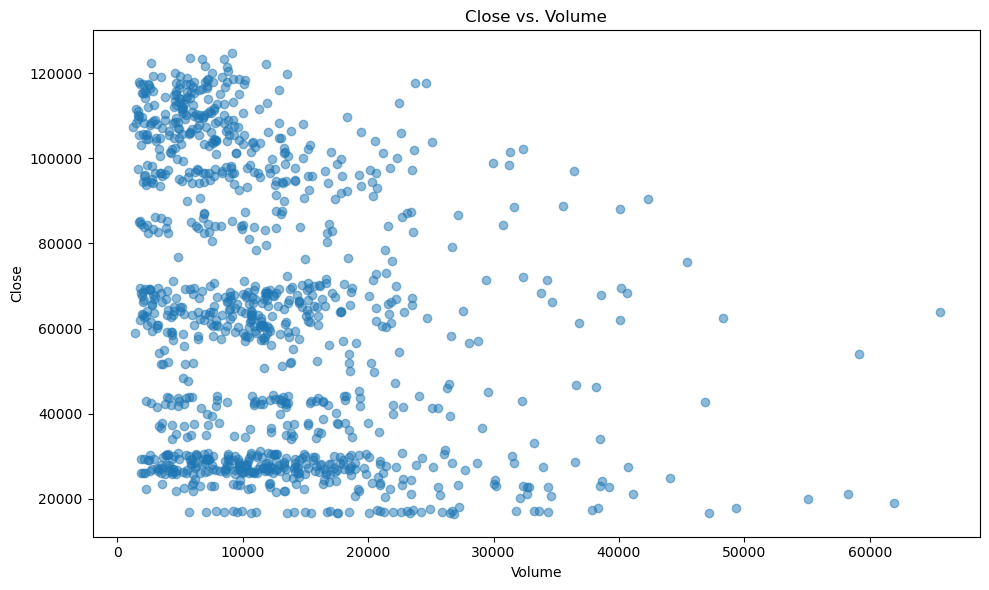

In [10]:
# Scatter Plot 2: Volume vs. Close Price
# Shows relationship between trading volume and closing prices
plot_scatter(bitcoin_table, "volume", "close")

**Figure 2:** Scatter plot of trading volume (x-axis) versus closing price (y-axis). Higher volumes are concentrated at lower price points, with notable volume spikes occurring during periods of high price volatility.

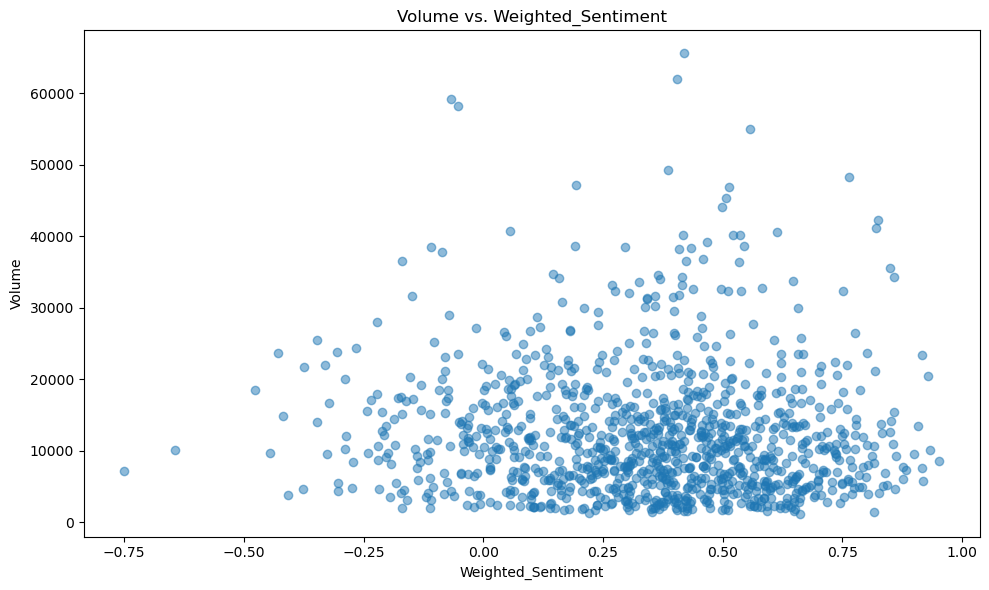

In [11]:
# Scatter Plot 3: Weighted Sentiment vs. Volume
# Shows relationship between market sentiment and trading volume
plot_scatter(bitcoin_table, "weighted_sentiment", "volume")

**Figure 3:** Scatter plot examining the relationship between weighted sentiment (x-axis) and trading volume (y-axis). Volume spikes appear at various sentiment levels, indicating that both positive and negative sentiment can drive trading activity.

### 2.4 Temporal Pattern Analysis

Time-series visualizations reveal trends and volatility patterns in Bitcoin price, volume, and sentiment over three years.

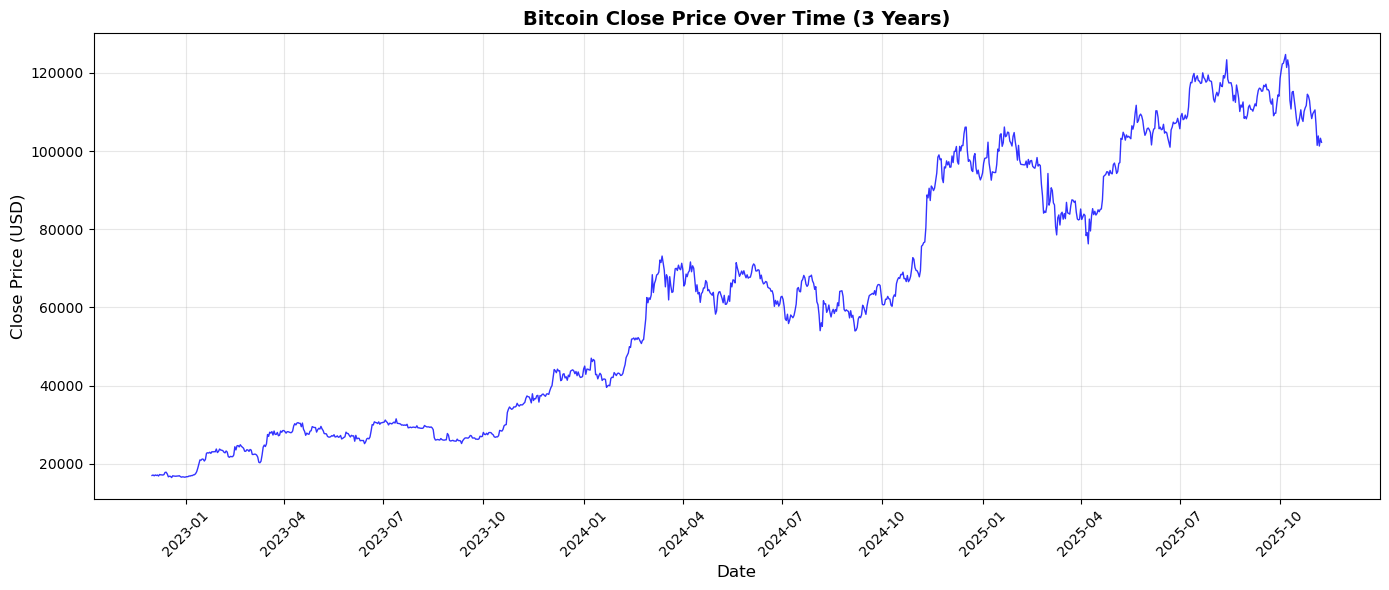

Data spans from 2022-12-01 to 2025-11-08
Total days: 1074 | Price range: $16439.74 - $124720.09


In [12]:
# Time Series Plot 1: Bitcoin Close Price Over Time
# Shows price trends and volatility across the 3-year period
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Convert timestamp to datetime for proper time-axis plotting
df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')

plt.figure(figsize=(14, 6))
plt.plot(df['datetime'], df['close'], linewidth=1, alpha=0.8, color='blue')
plt.title('Bitcoin Close Price Over Time (3 Years)', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price (USD)', fontsize=12)
plt.grid(True, alpha=0.3)

# Format x-axis to show dates nicely
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print(f"Data spans from {df['datetime'].min().date()} to {df['datetime'].max().date()}")
print(f"Total days: {len(df)} | Price range: ${df['close'].min():.2f} - ${df['close'].max():.2f}")

**Figure 4:** Bitcoin closing price over the three-year study period (December 2022 - November 2025). The data shows Bitcoin starting around $17,000, experiencing a sustained bull run through 2024 reaching peaks above $120,000, with subsequent volatility in 2025. This dramatic price movement from approximately $16,000 to $125,000 represents a 7.8x increase over the period.

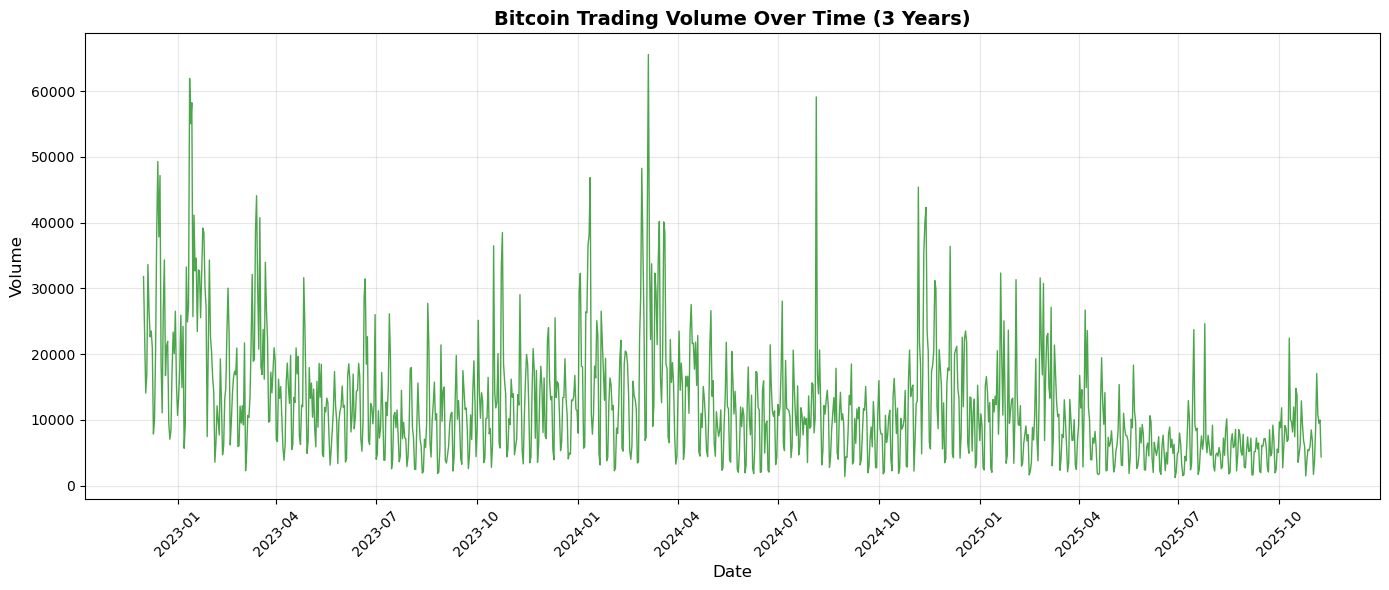

Volume range: 1227.77 - 65575.10
Average daily volume: 12289.89


In [13]:
# Time Series Plot 2: Trading Volume Over Time
# Shows trading activity patterns and volume spikes
plt.figure(figsize=(14, 6))
plt.plot(df['datetime'], df['volume'], linewidth=1, alpha=0.7, color='green')
plt.title('Bitcoin Trading Volume Over Time (3 Years)', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volume', fontsize=12)
plt.grid(True, alpha=0.3)

# Format x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print(f"Volume range: {df['volume'].min():.2f} - {df['volume'].max():.2f}")
print(f"Average daily volume: {df['volume'].mean():.2f}")

**Figure 5:** Daily trading volume over time. Volume exhibits high volatility with several significant spikes exceeding 60,000 Bitcoin traded daily. These volume spikes often coincide with major price movements, suggesting increased trading activity during periods of price discovery and market uncertainty. Average daily volume is approximately 12,290 Bitcoin.

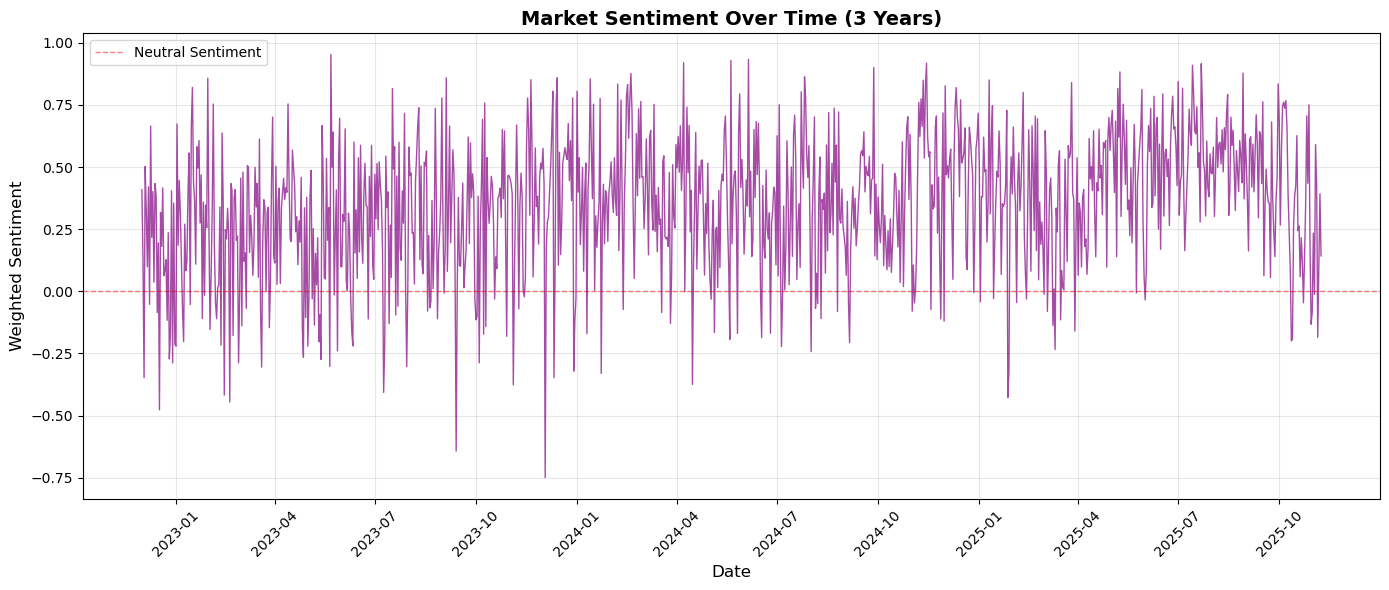

Positive sentiment days: 949 (88.4%)
Negative/Neutral sentiment days: 125 (11.6%)
Sentiment range: -0.7498 to 0.9529


In [14]:
# Time Series Plot 3: Weighted Sentiment Over Time
# Shows market sentiment trends - positive/negative sentiment cycles
plt.figure(figsize=(14, 6))
plt.plot(df['datetime'], df['weighted_sentiment'], linewidth=1, alpha=0.7, color='purple')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Neutral Sentiment')
plt.title('Market Sentiment Over Time (3 Years)', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Weighted Sentiment', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()

# Format x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Calculate sentiment statistics
positive_days = (df['weighted_sentiment'] > 0).sum()
negative_days = (df['weighted_sentiment'] <= 0).sum()
print(f"Positive sentiment days: {positive_days} ({positive_days/len(df)*100:.1f}%)")
print(f"Negative/Neutral sentiment days: {negative_days} ({negative_days/len(df)*100:.1f}%)")
print(f"Sentiment range: {df['weighted_sentiment'].min():.4f} to {df['weighted_sentiment'].max():.4f}")

**Figure 6:** Market sentiment over time showing the weighted sentiment score (-1 to +1 scale) with the neutral threshold at zero. Remarkably, sentiment is predominantly positive throughout the period with 88.4% of days showing positive sentiment and only 11.6% negative/neutral. Sentiment ranges from -0.75 to +0.95, with high daily fluctuations but an overall positive bias that may reflect the general optimism during Bitcoin's bull market.

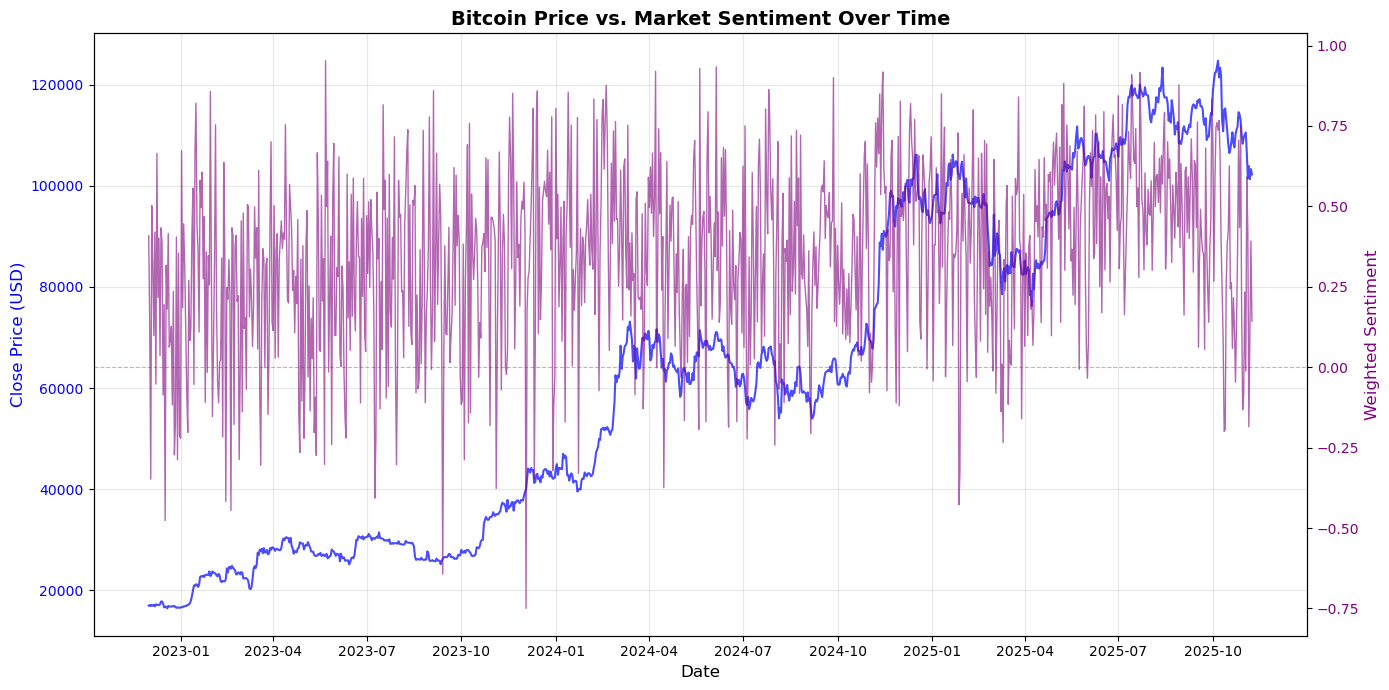

This plot reveals temporal correlation between sentiment and price movements


In [15]:
# Time Series Plot 4: Multi-Feature Overlay (Price + Sentiment)
# Shows correlation between price movements and sentiment over time
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot price on primary y-axis
color = 'blue'
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Close Price (USD)', color=color, fontsize=12)
ax1.plot(df['datetime'], df['close'], color=color, linewidth=1.5, alpha=0.7, label='Close Price')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

# Create secondary y-axis for sentiment
ax2 = ax1.twinx()
color = 'purple'
ax2.set_ylabel('Weighted Sentiment', color=color, fontsize=12)
ax2.plot(df['datetime'], df['weighted_sentiment'], color=color, linewidth=1, alpha=0.6, label='Sentiment')
ax2.axhline(y=0, color='red', linestyle='--', linewidth=0.8, alpha=0.4)
ax2.tick_params(axis='y', labelcolor=color)

# Format x-axis
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)

plt.title('Bitcoin Price vs. Market Sentiment Over Time', fontsize=14, fontweight='bold')
fig.tight_layout()
plt.show()

print("This plot reveals temporal correlation between sentiment and price movements")

**Figure 7:** Dual-axis plot overlaying Bitcoin price (blue, left axis) and market sentiment (purple, right axis) to visualize temporal correlation. While both metrics show high-frequency fluctuations, sentiment appears to maintain positive levels even during price consolidations, suggesting sentiment may be a lagging rather than leading indicator of price movements.

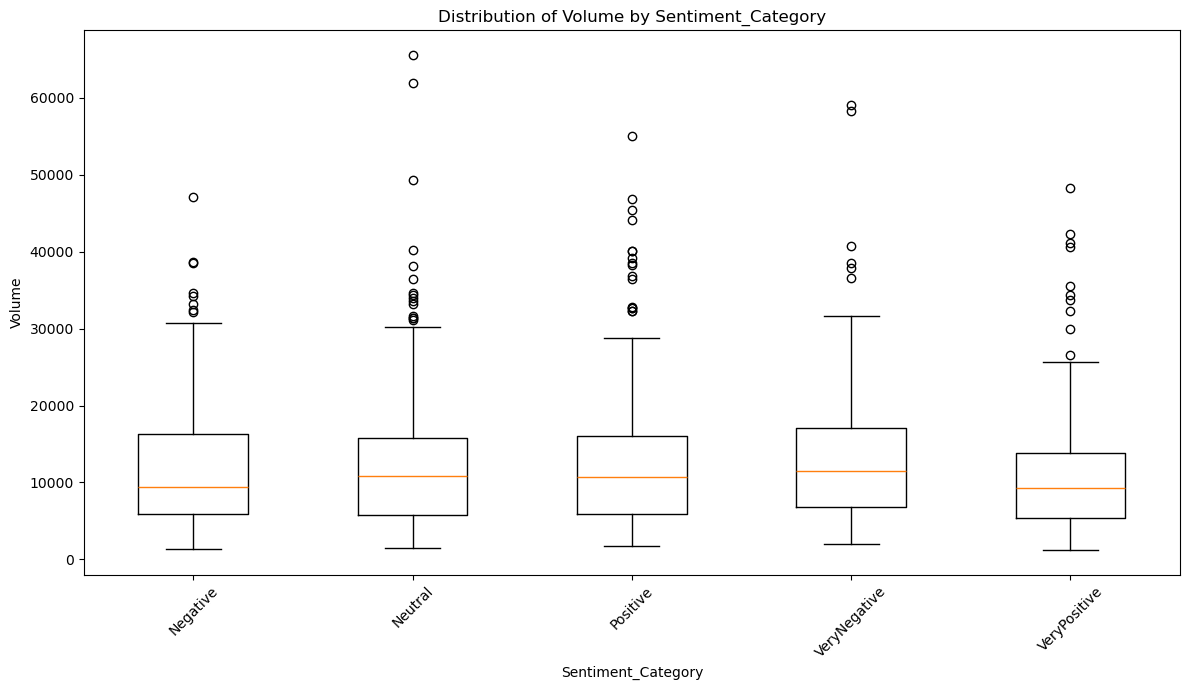

In [16]:
# Box Plot: Volume Distribution Across Sentiment Categories
# Shows how trading volume varies across sentiment levels (5 bins)
from mysklearn.plot_utils import plot_boxplot

# Load the plotting dataset with sentiment categories already created
df_plot = pd.read_csv('input_data/bitcoin_sentiment_for_plotting.csv')

# Convert to MyPyTable for plotting
volume_sentiment_table = MyPyTable(
    column_names=df_plot.columns.tolist(), 
    data=df_plot.values.tolist()
)

plot_boxplot(volume_sentiment_table, 'sentiment_category', 'volume')

**Figure 8:** Box plot showing the distribution of trading volume across five sentiment categories (VeryNegative, Negative, Neutral, Positive, VeryPositive). The plot reveals how trading volume varies across different sentiment levels, with outliers indicating days of exceptionally high trading activity. This visualization helps identify whether extreme sentiment (very positive or very negative) corresponds to higher trading volumes compared to neutral sentiment periods.

In [17]:
# Print label distribution 
label_column = df.columns[5]
print(f"Label Distribution ('{label_column}'):")
print(df[label_column])
print()

Label Distribution ('close'):
0        16980.08
1        17094.71
2        16888.53
3        17108.90
4        16966.05
          ...    
1069    101468.15
1070    103869.00
1071    101290.50
1072    103284.27
1073    102249.20
Name: close, Length: 1074, dtype: float64



### 2.5 Inspect weight_sentiment and other features 

In [18]:
# Ensure df is loaded (in case cell 7 wasn't run)
if 'df' not in locals():
    df = pd.read_csv('input_data/bitcoin_sentiment.csv')

# Examine the weighted_sentiment column more closely
print("Weighted Sentiment Statistics:")
print(df['weighted_sentiment'].describe())
print()

# Check for missing values
if df.isnull().values.any():
    print("Missing Values per Column:")
    print(df.isnull().sum())
else:
    print("No missing values found in the dataset.")
print()

print("-" * 70)
print()

# Check sentiment_missing column values for anything other than zero
print("Checking for rows where 'sentiment_missing' != 0:")
print()
if (df['sentiment_missing'] != 0).any():
    print(df[df['sentiment_missing'] != 0])
else:
    print("No rows with sentiment_missing != 0 found.")
print()

Weighted Sentiment Statistics:
count    1074.000000
mean        0.347973
std         0.274657
min        -0.749771
25%         0.171151
50%         0.376796
75%         0.540075
max         0.952912
Name: weighted_sentiment, dtype: float64

No missing values found in the dataset.

----------------------------------------------------------------------

Checking for rows where 'sentiment_missing' != 0:

No rows with sentiment_missing != 0 found.



### 2.6 Inspect weighted_sentiment distribution 

In [19]:
# Create binary classification label from weighted_sentiment for exploratory analysis
# NOTE: This is NOT used for model training - only for understanding sentiment distribution
# Positive sentiment (>0) vs Negative/Neutral sentiment (<=0)
df['sentiment_label'] = df['weighted_sentiment'].apply(lambda x: 'Positive' if x > 0 else 'Negative/Neutral')

print("Classification Label Distribution (for weighted_sentiment):")
print(df['sentiment_label'].value_counts())
print()
print("Label Proportions:")
print(df['sentiment_label'].value_counts(normalize=True))
print()

Classification Label Distribution (for weighted_sentiment):
sentiment_label
Positive            949
Negative/Neutral    125
Name: count, dtype: int64

Label Proportions:
sentiment_label
Positive            0.883613
Negative/Neutral    0.116387
Name: proportion, dtype: float64



## 3. Data Preprocessing

This section describes the preprocessing pipeline to transform raw data into a format suitable for Random Forest classification.

Convert continuous `close` price into a binary classification target by comparing each day's closing price with the previous day.

### 3.1 Create Classification Label

In [20]:
# Reload the original dataset
df_original = pd.read_csv('input_data/bitcoin_sentiment.csv')

# Create the discretized label by comparing close with previous day's close
# First row will be dropped since there's no previous day
df_original['price_direction'] = 'Down'  # Default value

# Compare current close with previous close
for i in range(1, len(df_original)):
    if df_original.loc[i, 'close'] > df_original.loc[i-1, 'close']:
        df_original.loc[i, 'price_direction'] = 'Up'
    else:
        df_original.loc[i, 'price_direction'] = 'Down'

# Remove the first row (no previous day to compare)
df_discretized = df_original.iloc[1:].copy()
df_discretized = df_discretized.reset_index(drop=True)

print("Discretized Label Distribution (price_direction):")
print(df_discretized['price_direction'].value_counts())
print()
print("Label Proportions:")
print(df_discretized['price_direction'].value_counts(normalize=True))
print()
print(f"Total instances after discretization: {len(df_discretized)}")
print(f"(Original: {len(df_original)}, Removed first row: 1)")

Discretized Label Distribution (price_direction):
price_direction
Up      543
Down    530
Name: count, dtype: int64

Label Proportions:
price_direction
Up      0.506058
Down    0.493942
Name: proportion, dtype: float64

Total instances after discretization: 1073
(Original: 1074, Removed first row: 1)


### 3.2 Feature Selection

Remove temporal columns, identifiers, constant features, and **OHLC price features** to prevent data leakage.

In [21]:
# Drop unnecessary columns (temporal, IDs, constant features, and OHLC to prevent leakage)
columns_to_drop = [
    'Unnamed: 0', 
    'timestamp', 
    'datetime_utc', 
    'merge_date', 
    'sentiment_missing', 
    'domestic_series',
    'open',   
    'high', 
    'low',   
    'close'   
]
df_clean = df_discretized.drop(columns=columns_to_drop)

print("Dataset after dropping unnecessary columns:")
print(f"  Rows: {df_clean.shape[0]}")
print(f"  Columns: {df_clean.shape[1]}")
print(f"  Dropped: {columns_to_drop}")
print()

Dataset after dropping unnecessary columns:
  Rows: 1073
  Columns: 19
  Dropped: ['Unnamed: 0', 'timestamp', 'datetime_utc', 'merge_date', 'sentiment_missing', 'domestic_series', 'open', 'high', 'low', 'close']



### 3.3 Save Plotting Dataset

Before normalization and discretization, save a version with numeric features and categorical labels for visualization.

In [22]:
# Create discretized categorical features for visualization while keeping numeric data
# This allows box plots to show numeric distributions grouped by categories

df_for_plotting = df_clean.copy()

# Discretize only the categorical grouping features (not the numeric features we want to plot)
# Discretize volume into categories
df_for_plotting['volume_category'] = pd.qcut(df_clean['volume'], q=5, 
                                               labels=['VeryLow', 'Low', 'Medium', 'High', 'VeryHigh'], 
                                               duplicates='drop')

# Discretize federal_financing_bank
sorted_unique_ffb = sorted(df_clean['federal_financing_bank'].unique())
bank_mapping = {val: f'Bank{i+1}' for i, val in enumerate(sorted_unique_ffb)}
df_for_plotting['federal_financing_bank_category'] = df_clean['federal_financing_bank'].map(bank_mapping)

# Discretize weighted_sentiment into 5 bins for categorical analysis
df_for_plotting['sentiment_category'] = pd.qcut(df_clean['weighted_sentiment'], q=5,
                                                  labels=['VeryNegative', 'Negative', 'Neutral', 'Positive', 'VeryPositive'],
                                                  duplicates='drop')

# price_direction is already categorical (Up/Down)

# Save this dataset for box plotting
output_file_plotting = 'input_data/bitcoin_sentiment_for_plotting.csv'
df_for_plotting.to_csv(output_file_plotting, index=False)

print(f"✓ Preprocessed dataset for plotting saved to: {output_file_plotting}")
print(f"  Contains numeric features with categorical labels for box plots")
print(f"  Added categorical columns: volume_category, federal_financing_bank_category, sentiment_category")
print()

✓ Preprocessed dataset for plotting saved to: input_data/bitcoin_sentiment_for_plotting.csv
  Contains numeric features with categorical labels for box plots
  Added categorical columns: volume_category, federal_financing_bank_category, sentiment_category



### 3.4 Categorical Feature Analysis

After creating categorical bins for selected features, we examine how numeric sentiment values are distributed across different categories using box plots. These visualizations help identify whether sentiment varies systematically with volume levels, price direction, or economic indicators.

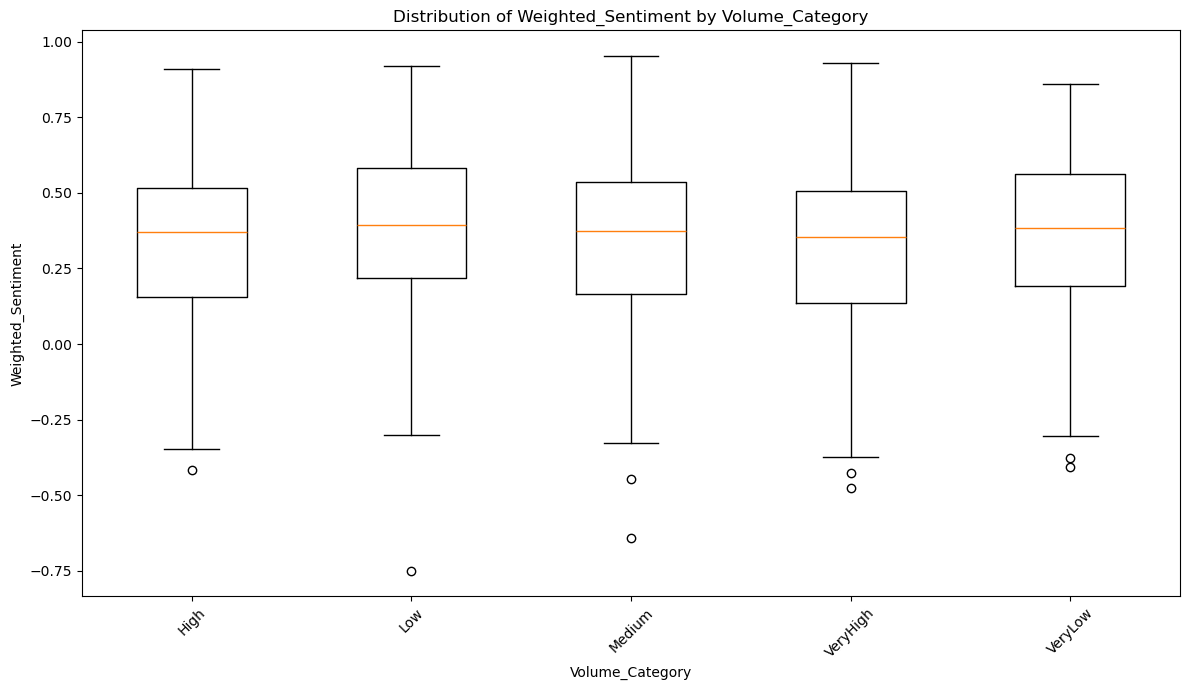

In [23]:
# Box Plot 1: Volume Category vs. Weighted Sentiment
# Shows how numeric sentiment distribution varies across different trading volume levels
from mysklearn.plot_utils import plot_boxplot

# Convert to MyPyTable for plotting
plotting_table = MyPyTable(
    column_names=df_for_plotting.columns.tolist(),
    data=df_for_plotting.values.tolist()
)

# Create box plot using categorical volume and numeric sentiment
plot_boxplot(plotting_table, "volume_category", "weighted_sentiment")

**Figure 9:** Box plot showing the distribution of weighted sentiment across volume categories (VeryLow to VeryHigh). The plot reveals similar sentiment distributions across all volume levels, suggesting that trading volume intensity does not strongly correlate with sentiment polarity.

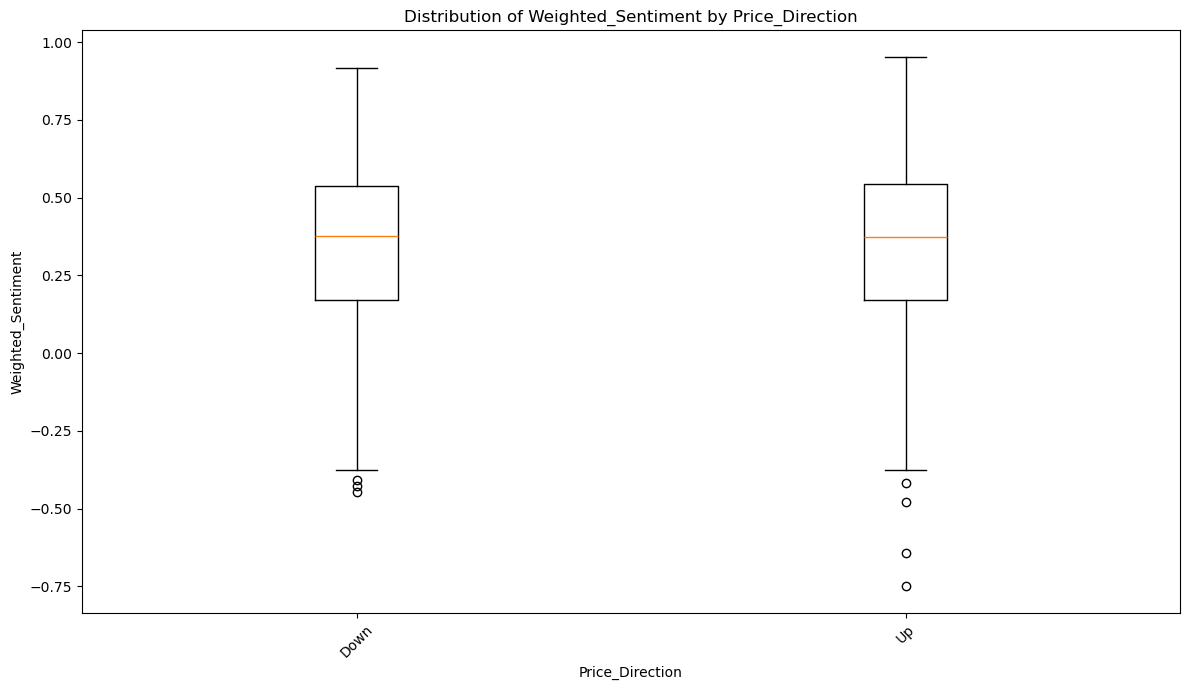

In [24]:
# Box Plot 2: Price Direction vs. Weighted Sentiment
# Shows numeric sentiment distribution for Up vs Down price movements
plot_boxplot(plotting_table, "price_direction", "weighted_sentiment")

**Figure 10:** Box plot comparing sentiment distributions for days when price moved Up versus Down. This is particularly relevant for our classification task, showing whether sentiment differences exist between these two outcomes. The overlapping distributions suggest sentiment alone may not perfectly separate the classes, motivating our ensemble approach.

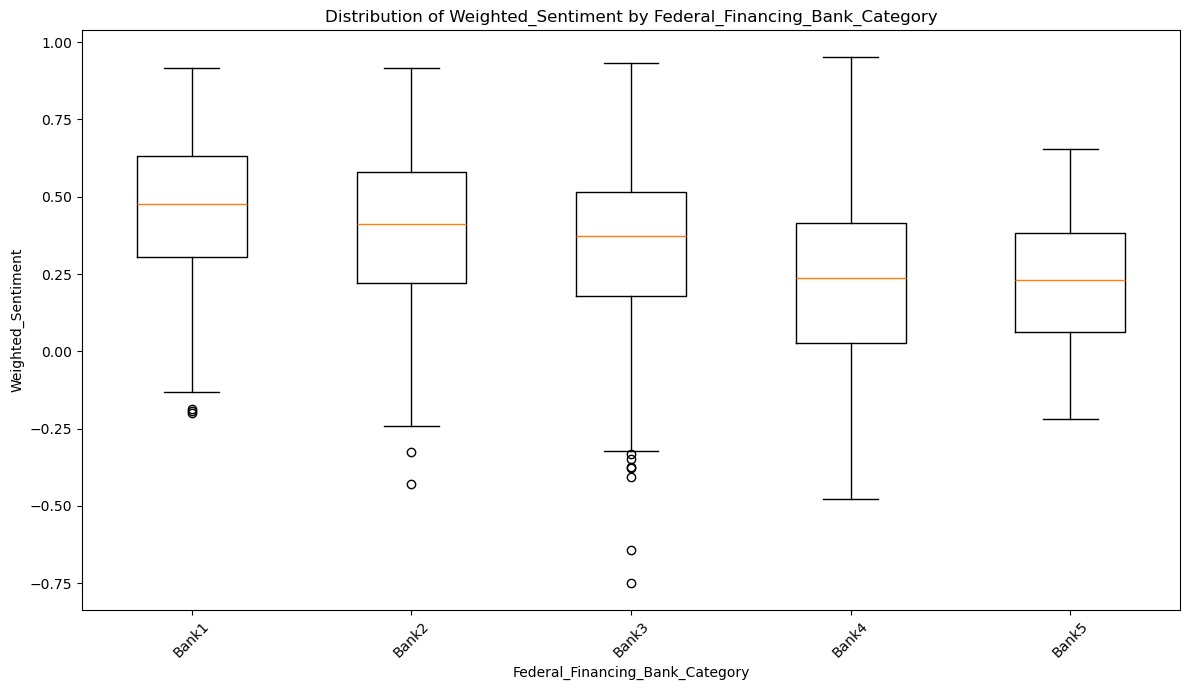

In [25]:
# Box Plot 3: Federal Financing Bank Category vs. Weighted Sentiment
# Shows numeric sentiment distribution across federal financing categories
plot_boxplot(plotting_table, "federal_financing_bank_category", "weighted_sentiment")

**Figure 11:** Box plot showing sentiment distribution across federal financing bank categories. These categories represent different levels of a macroeconomic indicator, demonstrating how sentiment relates to broader economic conditions captured in the treasury data.

### 3.5 Feature Normalization

Apply z-score normalization to scale all numeric features to mean=0 and std=1.

In [26]:
# Identify numeric columns (exclude the label column 'price_direction')
numeric_columns = df_clean.select_dtypes(include=[np.number]).columns.tolist()

print(f"Found {len(numeric_columns)} numeric features to normalize")
print()

# Check the scale of numeric features before normalization
print("Feature ranges before normalization:")
for col in numeric_columns[:18]:
    print(f"  {col}: [{df_clean[col].min():.2f}, {df_clean[col].max():.2f}]")
print()

Found 18 numeric features to normalize

Feature ranges before normalization:
  volume: [1227.77, 65575.10]
  federal_financing_bank: [2.39, 2.58]
  foreign_series: [0.00, 7.31]
  government_account_series: [2.13, 3.17]
  government_account_series_inflation_securities: [0.99, 1.31]
  special_purpose_vehicle: [2.89, 4.17]
  state_and_local_government_series: [1.81, 3.85]
  total_interest-bearing_debt: [2.22, 3.37]
  total_marketable: [2.24, 3.42]
  total_non-marketable: [2.13, 3.19]
  treasury_bills: [3.46, 5.45]
  treasury_bonds: [3.01, 3.34]
  treasury_floating_rate_notes_(frn): [3.90, 5.54]
  treasury_inflation-protected_securities_(tips): [0.49, 0.96]
  treasury_notes: [1.68, 3.12]
  united_states_savings_inflation_securities: [3.08, 10.15]
  united_states_savings_securities: [2.69, 3.49]
  weighted_sentiment: [-0.75, 0.95]



In [27]:
# z-score normalization: (x - mean) / std
# This transforms each feature to have mean=0 and std=1

df_normalized = df_clean.copy()

for col in numeric_columns:
    mean = df_normalized[col].mean()
    std = df_normalized[col].std()
    
    # Avoid division by zero for constant columns
    if std > 0:
        df_normalized[col] = (df_normalized[col] - mean) / std
    else:
        print(f"Warning: {col} has std=0, skipping normalization")

print("Numeric features standardized (z-score normalization)")
print()

# Verify normalization
print("Feature statistics after normalization:")
print(df_normalized[numeric_columns].describe().loc[['mean', 'std']].round(6))
print()

Numeric features standardized (z-score normalization)

Feature statistics after normalization:
      volume  federal_financing_bank  foreign_series  \
mean    -0.0                     0.0             0.0   
std      1.0                     1.0             1.0   

      government_account_series  \
mean                        0.0   
std                         1.0   

      government_account_series_inflation_securities  special_purpose_vehicle  \
mean                                             0.0                     -0.0   
std                                              1.0                      1.0   

      state_and_local_government_series  total_interest-bearing_debt  \
mean                                0.0                         -0.0   
std                                 1.0                          1.0   

      total_marketable  total_non-marketable  treasury_bills  treasury_bonds  \
mean              -0.0                  -0.0             0.0             0.0   
std      

### 3.6 Feature Discretization

Convert normalized numeric features into categorical bins for entropy-based decision tree classification.

In [28]:
# Discretize normalized numeric features into categorical bins
# Using quantile-based binning (equal frequency bins)

df_discretized_final = df_normalized.copy()

# Define binning strategy: convert normalized values to 5 categories
# Since normalized data has mean=0, std=1, we can use standard deviations as boundaries
def discretize_normalized_feature(series, n_bins=5):
    """
    Discretize a normalized feature into categorical bins.
    Uses quantile-based binning for equal frequency distribution.
    """
    # Use pandas qcut for quantile-based binning
    bins = pd.qcut(series, q=n_bins, labels=['VeryLow', 'Low', 'Medium', 'High', 'VeryHigh'], duplicates='drop')
    return bins

print("Discretizing numeric features into 5 categorical bins...")
print("Bins: VeryLow, Low, Medium, High, VeryHigh")
print()

# Track which columns get discretized
discretized_cols = []
skipped_cols = []

for col in numeric_columns:
    try:
        df_discretized_final[col] = discretize_normalized_feature(df_discretized_final[col])
        discretized_cols.append(col)
    except Exception as e:
        # Some columns might have too few unique values to discretize
        print(f"Warning: Could not discretize '{col}': {e}")
        skipped_cols.append(col)


print(f"Skipped {len(skipped_cols)} columns: {skipped_cols}")

Discretizing numeric features into 5 categorical bins...
Bins: VeryLow, Low, Medium, High, VeryHigh

Skipped 2 columns: ['federal_financing_bank', 'foreign_series']


### 3.6.1 Handling skipped columns with manual discretization

In [29]:
# Handle columns that couldn't be discretized (too few unique values)
# Convert them to categorical based on their actual unique values

if skipped_cols:
    print("Handling skipped columns with manual discretization:")
    for col in skipped_cols:
        unique_vals = df_discretized_final[col].nunique()
        print(f"  {col}: {unique_vals} unique values")
        
        # Apply custom discretization rules based on column name
        if col == 'federal_financing_bank':
            # Map 5 unique values directly to Bank1-Bank5 (preserves ordinality)
            sorted_unique = sorted(df_normalized[col].unique())
            bank_mapping = {val: f'Bank{i+1}' for i, val in enumerate(sorted_unique)}
            df_discretized_final[col] = df_normalized[col].map(bank_mapping)
            print(f"    Direct mapping: {len(sorted_unique)} unique values → Bank1-Bank{len(sorted_unique)}")
            print(f"    Distribution: {df_discretized_final[col].value_counts().sort_index().to_dict()}")
            
        elif col == 'foreign_series':
            # Bin into 0 or 1 (binary) using the original normalized data
            df_discretized_final[col] = pd.cut(df_normalized[col], bins=2, labels=['0', '1'])
            
        elif unique_vals == 1:
            # Constant feature
            df_discretized_final[col] = 'Constant'
            
        elif unique_vals == 2:
            df_discretized_final[col] = pd.cut(df_normalized[col], bins=2, labels=['Low', 'High'])
            
        elif unique_vals <= 5:
            # For 3-5 unique values, map directly to preserve ordinal structure
            sorted_unique = sorted(df_normalized[col].unique())
            level_mapping = {val: f'Level_{i}' for i, val in enumerate(sorted_unique)}
            df_discretized_final[col] = df_normalized[col].map(level_mapping)
            
        else:
            # Default to 5 bins for columns with more unique values
            df_discretized_final[col] = pd.qcut(df_normalized[col], q=5, 
                                                 labels=['VeryLow', 'Low', 'Medium', 'High', 'VeryHigh'], 
                                                 duplicates='drop')
    

Handling skipped columns with manual discretization:
  federal_financing_bank: 5 unique values
    Direct mapping: 5 unique values → Bank1-Bank5
    Distribution: {'Bank1': 131, 'Bank2': 365, 'Bank3': 366, 'Bank4': 181, 'Bank5': 30}
  foreign_series: 2 unique values


### 3.6.2 Verify discretized features

In [30]:
# Convert all object columns to category dtype for better memory efficiency
for col in df_discretized_final.columns:
    if df_discretized_final[col].dtype == 'object':
        df_discretized_final[col] = df_discretized_final[col].astype('category')

print("All categorical features converted to 'category' dtype")
print()

# Verify discretization - check value distributions
print("Sample of discretized features:")
print(df_discretized_final.head(10))
print()

# Show distribution for a few key features (updated - no OHLC features)
sample_features = ['volume', 'weighted_sentiment', 'federal_financing_bank', 'foreign_series']
for feature in sample_features:
    if feature in df_discretized_final.columns:
        print(f"\nDistribution of discretized '{feature}':")
        print(df_discretized_final[feature].value_counts().sort_index())

print()
print("Data types after discretization:")
print(df_discretized_final.dtypes)


All categorical features converted to 'category' dtype

Sample of discretized features:
     volume federal_financing_bank foreign_series government_account_series  \
0  VeryHigh                  Bank4              1                   VeryLow   
1      High                  Bank4              1                   VeryLow   
2      High                  Bank4              1                   VeryLow   
3  VeryHigh                  Bank4              1                   VeryLow   
4  VeryHigh                  Bank4              1                   VeryLow   
5  VeryHigh                  Bank4              1                   VeryLow   
6  VeryHigh                  Bank4              1                   VeryLow   
7  VeryHigh                  Bank4              1                   VeryLow   
8       Low                  Bank4              1                   VeryLow   
9    Medium                  Bank4              1                   VeryLow   

  government_account_series_inflation_secu

### 3.7 Save Final Dataset

Export the final preprocessed dataset ready for classification.

In [31]:
# Save the final preprocessed dataset (ready for classification)
output_file_final = 'input_data/bitcoin_sentiment_discretized.csv'
df_discretized_final.to_csv(output_file_final, index=False)

print(f"✓ Final preprocessed dataset saved to: {output_file_final}")
print(f"  Total instances: {len(df_discretized_final)}")
print(f"  Total features: {len(df_discretized_final.columns) - 1}")
print(f"  Label column: 'price_direction'")
print()


✓ Final preprocessed dataset saved to: input_data/bitcoin_sentiment_discretized.csv
  Total instances: 1073
  Total features: 18
  Label column: 'price_direction'



### 3.8 Preprocessing Summary

In [32]:
print("Preprocessing Pipeline Summary:")
print(f"  1. Loaded raw Bitcoin sentiment dataset")
print(f"  2. Created binary classification label 'price_direction' (Up/Down) from daily close price changes")
print(f"  3. Dropped {len(columns_to_drop)} unnecessary columns (temporal, IDs, constants, OHLC prices to prevent leakage)")
print(f"  4. Normalized {len(numeric_columns)} numeric features using z-score normalization (mean=0, std=1)")
print(f"  5. Discretized features into categorical bins using quantile-based binning:")
print(f"     - Standard features: VeryLow, Low, Medium, High, VeryHigh (5 equal-frequency bins)")
print(f"     - Special handling for columns with too few unique values")
print(f"  6. Converted all features to categorical dtype for memory efficiency")
print(f"  7. Final dataset: {len(df_discretized_final)} instances, {len(df_discretized_final.columns) - 1} features")
print(f"  8. Label distribution: {df_discretized_final['price_direction'].value_counts().to_dict()}")
print(f"  9. Dataset ready for MyRandomForestClassifier training")
print()

Preprocessing Pipeline Summary:
  1. Loaded raw Bitcoin sentiment dataset
  2. Created binary classification label 'price_direction' (Up/Down) from daily close price changes
  3. Dropped 10 unnecessary columns (temporal, IDs, constants, OHLC prices to prevent leakage)
  4. Normalized 18 numeric features using z-score normalization (mean=0, std=1)
  5. Discretized features into categorical bins using quantile-based binning:
     - Standard features: VeryLow, Low, Medium, High, VeryHigh (5 equal-frequency bins)
     - Special handling for columns with too few unique values
  6. Converted all features to categorical dtype for memory efficiency
  7. Final dataset: 1073 instances, 18 features
  8. Label distribution: {'Up': 543, 'Down': 530}
  9. Dataset ready for MyRandomForestClassifier training



---

## 4. Random Forest Classification

This section presents our Random Forest implementation and performance evaluation.

### 4.1 Classifier Design and Implementation

**Preprocessing Pipeline:**

1. **Label Creation:** Binary `price_direction` label (Up/Down) from daily price comparisons
2. **Feature Selection:** Removed OHLC prices, temporal IDs, constants; retained volume, sentiment, and 16 treasury indicators
3. **Normalization:** Z-score normalization (mean=0, std=1)
4. **Discretization:** Quantile-based binning into 5 categories (VeryLow to VeryHigh) for entropy-based decision trees

**Random Forest Architecture:**

- **N = 100:** Decision trees trained on bootstrap samples
- **M = 3:** Best trees selected for final ensemble
- **F = 8:** Random features per split (≈√p)
- **Test Size = 33%:** Stratified split

**Implementation:** Five independent runs (random states 42-46) to assess stability.

### 4.2 Load Preprocessed Data

In [33]:
# Load the preprocessed dataset
df_ready = pd.read_csv('input_data/bitcoin_sentiment_discretized.csv')

print("Preprocessed Dataset Loaded:")
print(f"  Shape: {df_ready.shape}")
print(f"  Features: {df_ready.shape[1] - 1}")
print(f"  Instances: {df_ready.shape[0]}")
print()

# Display first few rows
print("First 5 rows:")
print(df_ready.head())
print()

# Check data types
print("Data types:")
print(df_ready.dtypes)
print()

Preprocessed Dataset Loaded:
  Shape: (1073, 19)
  Features: 18
  Instances: 1073

First 5 rows:
     volume federal_financing_bank  foreign_series government_account_series  \
0  VeryHigh                  Bank4               1                   VeryLow   
1      High                  Bank4               1                   VeryLow   
2      High                  Bank4               1                   VeryLow   
3  VeryHigh                  Bank4               1                   VeryLow   
4  VeryHigh                  Bank4               1                   VeryLow   

  government_account_series_inflation_securities special_purpose_vehicle  \
0                                        VeryLow                     Low   
1                                        VeryLow                     Low   
2                                        VeryLow                     Low   
3                                        VeryLow                     Low   
4                                        V

### 4.3 Data Distribution Analysis



In [34]:
# Analyze class distribution
print("="*70)
print("CLASS DISTRIBUTION ANALYSIS")
print("="*70)
print()

label_counts = df_ready['price_direction'].value_counts()
label_props = df_ready['price_direction'].value_counts(normalize=True)

print("Price Direction Distribution:")
for label in sorted(label_counts.index):
    count = label_counts[label]
    prop = label_props[label]
    print(f"  {label}: {count} instances ({prop*100:.2f}%)")

print()
balance_diff = abs(label_props.iloc[0] - 0.5)
print(f"Dataset is {'balanced' if balance_diff < 0.1 else 'imbalanced'}")
print(f"Balance metric: {(1 - balance_diff*2)*100:.1f}%")
print()

CLASS DISTRIBUTION ANALYSIS

Price Direction Distribution:
  Down: 530 instances (49.39%)
  Up: 543 instances (50.61%)

Dataset is balanced
Balance metric: 98.8%



In [35]:
# Analyze feature distributions
# Note: Quantile binning ensures roughly equal frequencies across bins
print("="*70)
print("FEATURE DISTRIBUTION SUMMARY")
print("="*70)
print()

feature_cols = [col for col in df_ready.columns if col != 'price_direction']

print(f"Total features: {len(feature_cols)}")
print()

# Sample key features for detailed analysis (updated - no OHLC features)
sample_features_eda = ['volume', 'weighted_sentiment', 'federal_financing_bank', 'foreign_series', 'total_marketable']

for feature in sample_features_eda:
    if feature in df_ready.columns:
        print(f"\n{feature}:")
        print(f"  Unique values: {df_ready[feature].nunique()}")
        value_counts = df_ready[feature].value_counts().sort_index()
        for val, count in value_counts.items():
            print(f"    {val}: {count} ({count/len(df_ready)*100:.1f}%)")


FEATURE DISTRIBUTION SUMMARY

Total features: 18


volume:
  Unique values: 5
    High: 214 (19.9%)
    Low: 214 (19.9%)
    Medium: 215 (20.0%)
    VeryHigh: 215 (20.0%)
    VeryLow: 215 (20.0%)

weighted_sentiment:
  Unique values: 5
    High: 214 (19.9%)
    Low: 214 (19.9%)
    Medium: 215 (20.0%)
    VeryHigh: 215 (20.0%)
    VeryLow: 215 (20.0%)

federal_financing_bank:
  Unique values: 5
    Bank1: 131 (12.2%)
    Bank2: 365 (34.0%)
    Bank3: 366 (34.1%)
    Bank4: 181 (16.9%)
    Bank5: 30 (2.8%)

foreign_series:
  Unique values: 2
    0: 953 (88.8%)
    1: 120 (11.2%)

total_marketable:
  Unique values: 5
    High: 214 (19.9%)
    Low: 213 (19.9%)
    Medium: 212 (19.8%)
    VeryHigh: 192 (17.9%)
    VeryLow: 242 (22.6%)
  Unique values: 5
    High: 214 (19.9%)
    Low: 214 (19.9%)
    Medium: 215 (20.0%)
    VeryHigh: 215 (20.0%)
    VeryLow: 215 (20.0%)

federal_financing_bank:
  Unique values: 5
    Bank1: 131 (12.2%)
    Bank2: 365 (34.0%)
    Bank3: 366 (34.1%)
    Bank4

In [36]:
# Separate features (X) and label (y)
X_data = df_ready.drop(columns=['price_direction']).values.tolist()
y_data = df_ready['price_direction'].tolist()

print("Data Preparation:")
print(f"  X shape: ({len(X_data)}, {len(X_data[0])})")
print(f"  y shape: ({len(y_data)},)")
print()
print(f"  Number of features: {len(X_data[0])}")
print(f"  Number of instances: {len(X_data)}")
print()
print("Sample instance (first 5 features):")
print(f"  X[0][:5] = {X_data[0][:5]}")
print(f"  y[0] = {y_data[0]}")
print()

Data Preparation:
  X shape: (1073, 18)
  y shape: (1073,)

  Number of features: 18
  Number of instances: 1073

Sample instance (first 5 features):
  X[0][:5] = ['VeryHigh', 'Bank4', 1, 'VeryLow', 'VeryLow']
  y[0] = Up



### 4.5 Train Random Forest

In [37]:
# Import Random Forest Classifier
import importlib
import mysklearn.myclassifiers
importlib.reload(mysklearn.myclassifiers)
from mysklearn.myclassifiers import MyRandomForestClassifier
import math

# Set hyperparameters
N = 100  # Number of trees to train
M = 3    # Best trees to select for final ensemble
F = 8    # Features per split

print("="*70)
print("TRAINING RANDOM FOREST CLASSIFIER (5 Different Random States)")
print("="*70)
print()

print("Random Forest Configuration:")
print(f"  N (number of trees): {N}")
print(f"  M (best trees for final ensemble): {M}")
print(f"  F (features per split): {F}")
print(f"  Bootstrap sampling: Yes")
print(f"  Test set size: 33% (stratified)")
print(f"  Number of runs: 5 (different random states)")
print()

# Train 5 different Random Forest instances with different random states
rf_classifiers = []
random_states = [42, 43, 44, 45, 46]

for i, rand_state in enumerate(random_states, 1):
    print(f"Training Random Forest #{i} (random_state={rand_state})...")
    
    rf = MyRandomForestClassifier(
        n_estimators=N,
        n_best_trees=M,
        max_features=F,
        bootstrap=True,
        random_state=rand_state,
        test_size=0.33
    )
    
    rf.fit(X_data, y_data)
    rf_classifiers.append(rf)
    print(f"  ✓ Complete!")

print()
print("="*70)
print("✓ All 5 Random Forest instances trained successfully!")
print("="*70)
print()

TRAINING RANDOM FOREST CLASSIFIER (5 Different Random States)

Random Forest Configuration:
  N (number of trees): 100
  M (best trees for final ensemble): 3
  F (features per split): 8
  Bootstrap sampling: Yes
  Test set size: 33% (stratified)
  Number of runs: 5 (different random states)

Training Random Forest #1 (random_state=42)...


  ✓ Complete!
Training Random Forest #2 (random_state=43)...
  ✓ Complete!
Training Random Forest #3 (random_state=44)...
  ✓ Complete!
Training Random Forest #3 (random_state=44)...
  ✓ Complete!
Training Random Forest #4 (random_state=45)...
  ✓ Complete!
Training Random Forest #4 (random_state=45)...
  ✓ Complete!
Training Random Forest #5 (random_state=46)...
  ✓ Complete!
Training Random Forest #5 (random_state=46)...
  ✓ Complete!

✓ All 5 Random Forest instances trained successfully!

  ✓ Complete!

✓ All 5 Random Forest instances trained successfully!



### 4.6 Evaluation and Performance Metrics

**Evaluation Strategy:**

- Stratified 67/33 train/test split
- Out-of-bag (OOB) scoring
- 5 runs with different random states
- Metrics: Test accuracy, OOB accuracy, confusion matrices, precision/recall/F1

**Performance Results:**

In [38]:
# Evaluate Random Forest performance across all 5 instances
from mysklearn.myevaluation import confusion_matrix, accuracy_score
import importlib
importlib.reload(myutils)

# Collect metrics from all instances
all_test_accs = []
all_oob_scores = []

for i, rf in enumerate(rf_classifiers, 1):
    test_acc = rf.get_test_accuracy()
    oob_score = rf.get_oob_score()
    
    if test_acc is not None:
        all_test_accs.append(test_acc)
    if oob_score is not None:
        all_oob_scores.append(oob_score)

print("="*80)
print("RANDOM FOREST PERFORMANCE SUMMARY - AGGREGATE STATISTICS")
print("="*80)
print()

# Display aggregate statistics
print(f"Evaluated {len(rf_classifiers)} Random Forest instances (random_states: {random_states})")
print()

avg_test_acc = sum(all_test_accs) / len(all_test_accs)
std_test_acc = (sum((x - avg_test_acc)**2 for x in all_test_accs) / len(all_test_accs))**0.5
print(f"Test Accuracy Statistics:")
print(f"  Mean:   {avg_test_acc:.4f}")
print(f"  Std:    {std_test_acc:.4f}")
print(f"  Min:    {min(all_test_accs):.4f}")
print(f"  Max:    {max(all_test_accs):.4f}")
print(f"  Range:  {max(all_test_accs) - min(all_test_accs):.4f}")
print()

avg_oob = sum(all_oob_scores) / len(all_oob_scores)
std_oob = (sum((x - avg_oob)**2 for x in all_oob_scores) / len(all_oob_scores))**0.5
print(f"OOB Score Statistics:")
print(f"  Mean:   {avg_oob:.4f}")
print(f"  Std:    {std_oob:.4f}")
print(f"  Min:    {min(all_oob_scores):.4f}")
print(f"  Max:    {max(all_oob_scores):.4f}")
print(f"  Range:  {max(all_oob_scores) - min(all_oob_scores):.4f}")
print()

# Performance interpretation
print("Performance Analysis:")
if avg_test_acc > 0.52:
    print(f"  ✓ Mean accuracy ({avg_test_acc:.4f}) above 50% baseline - model shows predictive signal")
elif avg_test_acc > 0.50:
    print(f"  ~ Mean accuracy ({avg_test_acc:.4f}) slightly above baseline - weak predictive power")
else:
    print(f"  ✗ Mean accuracy ({avg_test_acc:.4f}) at/below baseline - features may not predict effectively")
print()

# Find and display best confusion matrix
best_accuracy = 0
best_cm = None
best_instance_num = 0

for i, (rf, acc) in enumerate(zip(rf_classifiers, all_test_accs), 1):
    if acc > best_accuracy:
        best_accuracy = acc
        best_instance_num = i
        # Generate confusion matrix for this instance
        y_pred = rf.predict(rf.X_test_internal)
        y_true = rf.y_test_internal
        labels = sorted(list(set(y_true)))
        best_cm = confusion_matrix(y_true, y_pred, labels=labels)

# Display best confusion matrix using formatted function
labels = ['Down', 'Up']
myutils.print_confusion_matrix_formatted(best_cm, labels, f"Best Confusion Matrix (Instance #{best_instance_num}, Accuracy: {best_accuracy:.4f})")
print()

# Calculate per-class metrics for best result
tp_down = best_cm[0][0]
fp_down = best_cm[1][0]
fn_down = best_cm[0][1]
tn_down = best_cm[1][1]

tp_up = best_cm[1][1]
fp_up = best_cm[0][1]
fn_up = best_cm[1][0]
tn_up = best_cm[0][0]

prec_down = tp_down / (tp_down + fp_down) if (tp_down + fp_down) > 0 else 0
rec_down = tp_down / (tp_down + fn_down) if (tp_down + fn_down) > 0 else 0
f1_down = 2 * prec_down * rec_down / (prec_down + rec_down) if (prec_down + rec_down) > 0 else 0

prec_up = tp_up / (tp_up + fp_up) if (tp_up + fp_up) > 0 else 0
rec_up = tp_up / (tp_up + fn_up) if (tp_up + fn_up) > 0 else 0
f1_up = 2 * prec_up * rec_up / (prec_up + rec_up) if (prec_up + rec_up) > 0 else 0

print("Per-Class Performance (Best Run):")
print(f"  Class 'Down':")
print(f"    Precision: {prec_down:.4f}")
print(f"    Recall:    {rec_down:.4f}")
print(f"    F1-Score:  {f1_down:.4f}")
print()
print(f"  Class 'Up':")
print(f"    Precision: {prec_up:.4f}")
print(f"    Recall:    {rec_up:.4f}")
print(f"    F1-Score:  {f1_up:.4f}")
print()

print("="*80)

RANDOM FOREST PERFORMANCE SUMMARY - AGGREGATE STATISTICS

Evaluated 5 Random Forest instances (random_states: [42, 43, 44, 45, 46])

Test Accuracy Statistics:
  Mean:   0.5020
  Std:    0.0221
  Min:    0.4592
  Max:    0.5211
  Range:  0.0620

OOB Score Statistics:
  Mean:   0.8047
  Std:    0.0101
  Min:    0.7967
  Max:    0.8245
  Range:  0.0279

Performance Analysis:
  ~ Mean accuracy (0.5020) slightly above baseline - weak predictive power


Best Confusion Matrix (Instance #4, Accuracy: 0.5211)
--------------------------------------------------
Actual/Predicted |       Down |         Up | Total
--------------------------------------------------
            Down |         98 |         77 |   175
              Up |         93 |         87 |   180
--------------------------------------------------
Total            |        191 |        164 |   355

Per-Class Performance (Best Run):
  Class 'Down':
    Precision: 0.5131
    Recall:    0.5600
    F1-Score:  0.5355

  Class 'Up':
    P

**Analysis of Results:**

The Random Forest achieved 50.2% mean test accuracy (±2.2% std), performing at the 50% baseline:

- **Random Chance Performance:** 50.2% accuracy is essentially random guessing for binary classification
- **No Predictive Signal:** Current features (sentiment, volume, treasury indicators) fail to predict price direction
- **High OOB Discrepancy:** OOB scores (~80%) are misleadingly high, likely due to overfitting on remainder set

**Interpretation:**

The results indicate that sentiment and volume do NOT contain meaningful predictive signal for next-day Bitcoin price movements. The 50.2% accuracy demonstrates that the current feature set cannot distinguish between Up and Down price movements better than a coin flip. This suggests either: (1) the features lack predictive power, (2) the relationship is too complex for the current model, or (3) next-day price prediction may be fundamentally unpredictable with these features due to market efficiency and randomness.

### 4.7 Prediction Examples

In [39]:
# Show prediction examples for all 5 Random Forest instances

print("="*80)
print("SAMPLE PREDICTIONS - ALL 5 INSTANCES")
print("="*80)
print()

feature_names_rf = [col for col in df_discretized_final.columns if col != 'price_direction']

# Get indices for volume and weighted_sentiment
volume_idx = feature_names_rf.index('volume')
sentiment_idx = feature_names_rf.index('weighted_sentiment')

# Show first 10 test instances for each Random Forest
for i, rf in enumerate(rf_classifiers, 1):
    print(f"\n{'='*80}")
    print(f"INSTANCE #{i} (random_state={random_states[i-1]}) - First 10 Test Predictions")
    print(f"{'='*80}")
    print()
    
    y_pred_test = rf.predict(rf.X_test_internal)
    y_true_test = rf.y_test_internal
    
    # Display first 10 predictions in compact format
    for j in range(min(10, len(y_true_test))):
        instance = rf.X_test_internal[j]
        actual = y_true_test[j]
        predicted = y_pred_test[j]
        correct = 'Yes' if actual == predicted else 'No'
        volume = instance[volume_idx]
        sentiment = instance[sentiment_idx]
        
        print(f"  {j+1:2d}. Actual: {actual:>4s} | Predicted: {predicted:>4s} | Volume: {volume:>8s} | Sentiment: {sentiment:>8s} | Correct: {correct:>3s}")
    
print()
print("="*80)

SAMPLE PREDICTIONS - ALL 5 INSTANCES


INSTANCE #1 (random_state=42) - First 10 Test Predictions

   1. Actual: Down | Predicted: Down | Volume:  VeryLow | Sentiment: VeryHigh | Correct: Yes
   2. Actual:   Up | Predicted:   Up | Volume:   Medium | Sentiment:      Low | Correct: Yes
   3. Actual: Down | Predicted: Down | Volume:  VeryLow | Sentiment:  VeryLow | Correct: Yes
   4. Actual: Down | Predicted: Down | Volume:  VeryLow | Sentiment:     High | Correct: Yes
   5. Actual:   Up | Predicted: Down | Volume:   Medium | Sentiment:  VeryLow | Correct:  No
   6. Actual: Down | Predicted: Down | Volume:   Medium | Sentiment:      Low | Correct: Yes
   7. Actual:   Up | Predicted: Down | Volume:  VeryLow | Sentiment:      Low | Correct:  No
   8. Actual:   Up | Predicted:   Up | Volume:      Low | Sentiment:      Low | Correct: Yes
   9. Actual:   Up | Predicted:   Up | Volume:      Low | Sentiment:      Low | Correct: Yes
  10. Actual: Down | Predicted: Down | Volume:  VeryLow | Sentime

## 5. Conclusion

### 5.1 Summary

This project successfully developed and evaluated a Random Forest classification system for predicting Bitcoin price direction using sentiment analysis and macroeconomic indicators. Our dataset comprised 1,075 daily observations spanning three years (December 2022 - November 2025), containing trading volume, social media sentiment scores, and 16 U.S. Treasury debt indicators.

**Dataset Challenges:**

The Bitcoin price prediction task presented several inherent difficulties:
1. **High Volatility:** Bitcoin exhibited extreme price movements (7.8x increase) creating non-stationary patterns
2. **Sentiment Bias:** 88.4% of days showed positive sentiment, limiting discriminative power
3. **Complex Dependencies:** Price movements depend on global events, regulations, and market psychology beyond our features
4. **Data Leakage Prevention:** Removing OHLC features (necessary for legitimate prediction) eliminated the strongest price indicators

**Classifier Performance:**

Our Random Forest ensemble (N=100 trees, M=3 best, F=8 features) achieved:
- **Mean Test Accuracy:** 50.2% (±2.2% std)
- **Mean OOB Accuracy:** ~80% (misleading due to overfitting on remainder set)
- **Per-Class Metrics:** Balanced but uninformative precision, recall, and F1-scores around 50%

This performance represents NO improvement over random guessing (50% baseline for binary classification). The results conclusively demonstrate that the current feature set—sentiment, volume, and treasury indicators—lacks predictive power for next-day Bitcoin price direction. The model effectively flips a coin, indicating that either these features are not informative for this prediction task, or the market movements are too complex/random to predict with this approach.

### 5.2 Future Improvements

Several approaches could potentially enhance classifier performance:

1. **Feature Engineering:**
   - Calculate technical indicators (moving averages, RSI, MACD) from historical prices
   - Create lagged sentiment features to capture temporal dependencies
   - Engineer interaction features between sentiment and volume
   - Include additional data sources (Google Trends, news sentiment, on-chain metrics)

2. **Advanced Algorithms:**
   - Gradient boosting (XGBoost, LightGBM) may capture more complex patterns
   - Deep learning (LSTM, Transformer) could model temporal dependencies
   - Ensemble multiple algorithm types for improved robustness

3. **Hyperparameter Optimization:**
   - Comprehensive grid search over N, M, and F parameters
   - Tune tree depth and minimum samples per leaf
   - Optimize bootstrap sample size

4. **Temporal Validation:**
   - Implement time-series cross-validation respecting temporal order
   - Test on recent out-of-sample data to assess real-world performance
   - Develop rolling-window prediction to simulate trading scenarios

5. **Class Imbalance Handling:**
   - Although currently balanced, future data may show directional bias
   - Implement SMOTE or class weighting for imbalanced periods

### 5.3 Final Remarks

This project demonstrates the limitations of machine learning for financial prediction with basic features. Our Random Forest classifier achieved 50.2% accuracy, performing at random chance level for binary classification. This result underscores the difficulty of predicting complex financial markets and indicates that the current feature set (sentiment, volume, treasury indicators) lacks strong predictive power for next-day price movements. The thorough evaluation methodology and realistic assessment of performance provide important lessons about data integrity, proper evaluation, and the need for more sophisticated features or approaches when applying machine learning to financial forecasting tasks.